# Energy Allocation

In [1]:
#using Pkg
#Pkg.add("XLSX")

In [2]:
using XLSX, Gurobi, StatsBase, CSV, DataFrames, 
JuMP, LinearAlgebra, Distributions, Random,
GLMNet, ScikitLearn, MLBase, CategoricalArrays, Plots,
Dates, Clustering, Distances, StatsPlots, ProgressMeter, 
StableRNGs, ParallelKMeans

In [3]:
# Read xlsm file
initial_df = DataFrame(XLSX.readtable("eCO2mix_RTE_Annuel-Definitif_2020.xlsm", "eCO2mix_RTE_Annuel-Definitif_20"));

In [4]:
# Let's clean the data

# Remove all rows with missing values
df = dropmissing(initial_df, disallowmissing=true);

# remove every columns before the Date column and after the Ech. comm. Allemagne-Belgique column
df = df[:, 3:23]

# put the columns PrÈvision J-1, PrÈvision J, Pompage, Ech. physiques
prev_pomp_df = df[:, [4, 5, 13, 15]]
# drom column 4,5,13,15
df = df[:, Not([4, 5, 13, 15])]

# rename the columns
rename!(df, Symbol.(["Date", "Time", "Consumption", "Fuel", "Coal", "Gas", "Nuclear", "Wind", "Solar", "Hydraulic", "Bioenergy", "CO2", "England", "Spain", "Italy", "Switzerland", "Germany_Belgium"]))

# for each country, we will divide in import and export, depending on the sign of the corresponding column

neighbors_columns = ["England", "Spain", "Italy", "Switzerland", "Germany_Belgium"]
for col in neighbors_columns
    # create a new import column, which values are positive if the original column is positive, and 0 otherwise
    df[!, Symbol(col * "_import")] = max.(df[!, Symbol(col)], 0)
    # create a new export column, which values are positive if the original column is negative, and 0 otherwise
    df[!, Symbol(col * "_export")] = max.(-df[!, Symbol(col)], 0)
end

# drop the original columns
df = df[:, Not(neighbors_columns)]


# convert the date column to a string
df[!, :Date] = string.(df[!, :Date])
# convert the time column to a string
df[!, :Time] = string.(df[!, :Time])
# merge the date and time columns into a single column
df[!, :DateTime] = df[!, :Date] .* " " .* df[!, :Time]
# convert the DateTime column to a DateTime type
df[!, :DateTime] = DateTime.(df[!, :DateTime], "yyyy-mm-dd HH:MM:SS")
# convert date and time columns to a DateTime type
df[!, :Date] = Date.(df[!, :Date], "yyyy-mm-dd")
df[!, :Time] = Time.(df[!, :Time], "HH:MM:SS")

# sort the dataframe by DateTime
df = sort(df, :DateTime)
# put the DateTime column as the first column
df = df[:, [end; 1:end-1]]

# the units are in MWh
# convert the Any type to Float64
df[!, :Consumption] = convert(Array{Float64}, df[!, :Consumption])
df[!, :Fuel] = convert(Array{Float64}, df[!, :Fuel])
df[!, :Coal] = convert(Array{Float64}, df[!, :Coal])
df[!, :Gas] = convert(Array{Float64}, df[!, :Gas])
df[!, :Nuclear] = convert(Array{Float64}, df[!, :Nuclear])
df[!, :Wind] = convert(Array{Float64}, df[!, :Wind])
df[!, :Solar] = convert(Array{Float64}, df[!, :Solar])
df[!, :Hydraulic] = convert(Array{Float64}, df[!, :Hydraulic])
df[!, :Bioenergy] = convert(Array{Float64}, df[!, :Bioenergy])
df[!, :CO2] = convert(Array{Float64}, df[!, :CO2])
df[!, :England_import] = convert(Array{Float64}, df[!, :England_import])
df[!, :England_export] = convert(Array{Float64}, df[!, :England_export])
df[!, :Spain_import] = convert(Array{Float64}, df[!, :Spain_import])
df[!, :Spain_export] = convert(Array{Float64}, df[!, :Spain_export])
df[!, :Italy_import] = convert(Array{Float64}, df[!, :Italy_import])
df[!, :Italy_export] = convert(Array{Float64}, df[!, :Italy_export])
df[!, :Switzerland_import] = convert(Array{Float64}, df[!, :Switzerland_import])
df[!, :Switzerland_export] = convert(Array{Float64}, df[!, :Switzerland_export])
df[!, :Germany_Belgium_import] = convert(Array{Float64}, df[!, :Germany_Belgium_import])
df[!, :Germany_Belgium_export] = convert(Array{Float64}, df[!, :Germany_Belgium_export])

df


Row,DateTime,Date,Time,Consumption,Fuel,Coal,Gas,Nuclear,Wind,Solar,Hydraulic,Bioenergy,CO2,England_import,England_export,Spain_import,Spain_export,Italy_import,Italy_export,Switzerland_import,Switzerland_export,Germany_Belgium_import,Germany_Belgium_export
,DateTime,Date,Time,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2020-01-01T00:00:00,2020-01-01,00:00:00,67068.0,300.0,14.0,6515.0,49226.0,3748.0,0.0,9084.0,1185.0,40.0,0.0,1704.0,0.0,226.0,0.0,1954.0,0.0,2267.0,1763.0,0.0
2,2020-01-01T00:30:00,2020-01-01,00:30:00,66103.0,107.0,13.0,6692.0,49436.0,3627.0,0.0,9586.0,1194.0,39.0,0.0,1704.0,0.0,226.0,0.0,1954.0,0.0,2267.0,1763.0,0.0
3,2020-01-01T01:00:00,2020-01-01,01:00:00,63943.0,106.0,13.0,6257.0,48970.0,3203.0,0.0,9133.0,1188.0,37.0,0.0,1704.0,358.0,0.0,0.0,1867.0,0.0,2527.0,1035.0,0.0
4,2020-01-01T01:30:00,2020-01-01,01:30:00,63904.0,107.0,14.0,5630.0,49648.0,2981.0,0.0,9124.0,1187.0,34.0,0.0,1704.0,358.0,0.0,0.0,1867.0,0.0,2527.0,1085.0,0.0
5,2020-01-01T02:00:00,2020-01-01,02:00:00,63408.0,107.0,14.0,5337.0,49764.0,2799.0,0.0,8699.0,1198.0,33.0,0.0,1704.0,301.0,0.0,0.0,1480.0,0.0,2463.0,1668.0,0.0
6,2020-01-01T02:30:00,2020-01-01,02:30:00,62711.0,107.0,15.0,4495.0,49747.0,2763.0,0.0,8212.0,1184.0,29.0,0.0,1704.0,301.0,0.0,0.0,1480.0,0.0,2463.0,1761.0,0.0
7,2020-01-01T03:00:00,2020-01-01,03:00:00,60825.0,107.0,14.0,3660.0,49527.0,2810.0,0.0,7658.0,1185.0,26.0,0.0,1704.0,614.0,0.0,0.0,1400.0,0.0,2350.0,595.0,0.0
8,2020-01-01T03:30:00,2020-01-01,03:30:00,59332.0,107.0,14.0,2942.0,49887.0,2822.0,0.0,7335.0,1194.0,22.0,0.0,1704.0,614.0,0.0,0.0,1400.0,0.0,2350.0,499.0,0.0
9,2020-01-01T04:00:00,2020-01-01,04:00:00,58004.0,107.0,13.0,2942.0,49299.0,2752.0,0.0,7021.0,1201.0,23.0,0.0,1704.0,1109.0,0.0,0.0,969.0,0.0,2402.0,237.0,0.0


In [5]:
# create a daily average production dataframe
df_daily = combine(groupby(df, :Date), :Solar => mean => :Solar_mean, :Wind => mean => :Wind_mean, :Hydraulic => mean => :Hydraulic_mean, :Bioenergy => mean => :Bioenergy_mean, :Nuclear => mean => :Nuclear_mean, :Gas => mean => :Gas_mean, :Coal => mean => :Coal_mean, :Fuel => mean => :Fuel_mean, :Consumption => mean => :Consumption_mean)
# sort the dataframe by date
df_daily = sort(df_daily, :Date)
# plot the data
#plot(df_daily[!, :Date], df_daily[!, :Solar_mean], label="Solar production", xlabel="Date", ylabel="Solar production", title="Daily average solar production respect to the time")
#plot(df_daily[!, :Date], df_daily[!, :Wind_mean], label="Wind production")
#plot(df_daily[!, :Date], df_daily[!, :Hydraulic_mean], label="Hydraulic production")
#plot(df_daily[!, :Date], df_daily[!, :Bioenergy_mean], label="Bioenergy production")
#plot(df_daily[!, :Date], df_daily[!, :Nuclear_mean], label="Nuclear production")
#plot(df_daily[!, :Date], df_daily[!, :Gas_mean], label="Gas production")
#plot(df_daily[!, :Date], df_daily[!, :Coal_mean], label="Coal production")
#plot(df_daily[!, :Date], df_daily[!, :Fuel_mean], label="Fuel production")
#plot(df_daily[!, :Date], df_daily[!, :Consumption_mean], label="Consumption")

Row,Date,Solar_mean,Wind_mean,Hydraulic_mean,Bioenergy_mean,Nuclear_mean,Gas_mean,Coal_mean,Fuel_mean,Consumption_mean
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2020-01-01,485.438,1750.29,8183.83,1177.31,49636.0,4675.94,14.3958,111.708,60786.0
2,2020-01-02,472.396,3404.94,9179.15,1170.25,50280.0,7237.62,13.5,108.167,64966.6
3,2020-01-03,381.667,7271.29,8232.92,1160.15,49103.7,6556.58,15.1042,113.854,63830.4
4,2020-01-04,604.792,3247.65,7536.02,1151.08,48255.1,6203.42,17.7083,105.542,60931.6
5,2020-01-05,797.896,1609.9,7326.73,1130.88,50006.7,7182.58,11.5625,104.5,60551.5
6,2020-01-06,760.5,4051.73,8087.75,1102.69,51969.6,7428.62,104.021,181.938,69904.6
7,2020-01-07,415.458,4119.0,9663.65,1149.25,52089.7,7875.96,14.7708,121.458,68540.2
8,2020-01-08,595.562,4286.92,9149.54,1161.83,51929.5,7375.1,18.375,117.583,65545.9
9,2020-01-09,686.5,9540.17,8665.98,1164.06,46154.6,5810.23,21.9583,116.542,63750.8


### Eco-cost synthetic data

For each source s, at each time t, we need an Eco-cost $f_{s,t}$

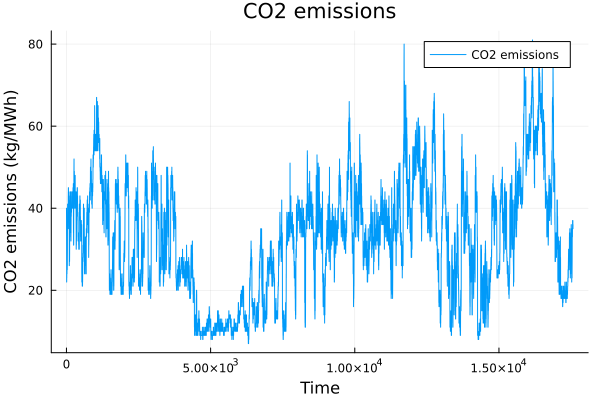

In [6]:
CO2 = df[!, :CO2]

# Plot the CO2 emissions
plot(CO2, title="CO2 emissions", xlabel="Time", ylabel="CO2 emissions (kg/MWh)", label="CO2 emissions")

In [7]:
mean_CO2 = mean(CO2)
println("The mean CO2 emissions are $(mean_CO2) kg/MWh")

# 1 GJ = 0.277778 MWh
mean_CO2_GJ = mean_CO2 / 0.277778
println("The mean CO2 emissions are $(mean_CO2_GJ) kg/GJ")



The mean CO2 emissions are 32.658185336976324 kg/MWh
The mean CO2 emissions are 117.56937315761623 kg/GJ


In [8]:
Eco_cost_footprint = [0.0347, 0.0003, 0.0175, 0.0003, 0.0281, 0.0002, 0.0030, 0.0164, 0.0130, 0.0193, 0.0172, 0.0067, 0.0226, 0.0065, 0.0109, 0.0024, 0.0136, 0.0099, 0.0154, 0.0270, 0.0099, 0.0095, 0.0084, 0.0006, 0.0091, 0.0156]
carbon_footprint_equiv = [0.30, 0.0023, 0.15, 0.00, 0.24, 0.0017, 0.03, 0.14, 0.11, 0.17, 0.15, 0.06, 0.19, 0.06, 0.09, 0.02, 0.12, 0.09, 0.13, 0.23, 0.08, 0.08, 0.07, 0.01, 0.08, 0.13]

# compute the mean of carbon_footprint_equiv / Eco_cost_footprint
mean_Eco_cost_carbon_footprint_equiv =  1 / mean(carbon_footprint_equiv ./ Eco_cost_footprint)

0.11652081241930631

In [9]:
function compute_eco_costs(df)

    # add values human_health, eco_toxicity, resource_scarcity, carbon_footprint for each source of energy, based on US Idemat Data
    fuel_info = [0.00246, 0.00821, 0.00007, 0.0281]
    coal_info = [0.00340, 0.00497, 0.00046, 0.0347]
    gas_info = [0.00324, 0.00294, 0.00013, 0.0175]
    nuclear_info = [0.00008, 0.00051, 0.03812, 0.0003]

    # we approximate all renewable energy sources with the same values
    hydraulic_info = [0.00002, 0.00003, 0.00017, 0.0002]
    bioenergy_info = [0.00002, 0.00003, 0.00017, 0.0002]
    wind_info = [0.00002, 0.00003, 0.00017, 0.0002]
    solar_info = [0.00002, 0.00003, 0.00017, 0.0002]

    # get the mean production of each source of energy
    mean_hydraulic = mean(df[!, :Hydraulic])
    mean_bioenergy = mean(df[!, :Bioenergy])
    mean_wind = mean(df[!, :Wind])
    mean_solar = mean(df[!, :Solar])
    mean_nuclear = mean(df[!, :Nuclear])
    mean_gas = mean(df[!, :Gas])
    mean_coal = mean(df[!, :Coal])
    mean_fuel = mean(df[!, :Fuel])

    # get the percentage of use of each source of energy
    total_production = mean_hydraulic + mean_bioenergy + mean_wind + mean_solar + mean_nuclear + mean_gas + mean_coal + mean_fuel
    percentage_hydraulic = mean_hydraulic / total_production
    percentage_bioenergy = mean_bioenergy / total_production
    percentage_wind = mean_wind / total_production
    percentage_solar = mean_solar / total_production
    percentage_nuclear = mean_nuclear / total_production
    percentage_gas = mean_gas / total_production
    percentage_coal = mean_coal / total_production
    percentage_fuel = mean_fuel / total_production

    # sum infos using the percentage of use of each source of energy
    sum_info = percentage_hydraulic * hydraulic_info + percentage_bioenergy * bioenergy_info + percentage_wind * wind_info + percentage_solar * solar_info + percentage_nuclear * nuclear_info + percentage_gas * gas_info + percentage_coal * coal_info + percentage_fuel * fuel_info;


    idemat_eco_cost_per_GJ = 18.19 # in euros/GJ
    idemat_carbon_footprint_per_GJ = 20.40 # in kg/GJ

    idemat_eco_costs = [0.21, 0.78, 14.83, 2.37] # in euros/GJ
    idemat_proportions = idemat_eco_costs / sum(idemat_eco_costs)
    # for each value in sum_info, determine the percentage of use of each source of energy

    # percentages of impact of each source of energy on eco_cost
    percentages_hydraulic = percentage_hydraulic .* hydraulic_info ./ sum_info .* idemat_proportions
    percentages_bioenergy = percentage_bioenergy .* bioenergy_info ./ sum_info .* idemat_proportions
    percentages_wind = percentage_wind .* wind_info ./ sum_info .* idemat_proportions
    percentages_solar = percentage_solar .* solar_info ./ sum_info .* idemat_proportions
    percentages_nuclear = percentage_nuclear .* nuclear_info ./ sum_info .* idemat_proportions
    percentages_gas = percentage_gas .* gas_info ./ sum_info .* idemat_proportions
    percentages_coal = percentage_coal .* coal_info ./ sum_info .* idemat_proportions
    percentages_fuel = percentage_fuel .* fuel_info ./ sum_info .* idemat_proportions


    idemat_eco_cost_per_MWh = idemat_eco_cost_per_GJ  / 3.6
    idemat_carbon_footprint_per_MWh = idemat_carbon_footprint_per_GJ / 3.6

    real_eco_cost_per_MWh = idemat_eco_cost_per_MWh / idemat_carbon_footprint_per_MWh * mean_CO2
    real_eco_costs = idemat_proportions * real_eco_cost_per_MWh # in euros/MWh

    # in euros/MWh
    eco_costs_hydraulic = percentages_hydraulic .* real_eco_cost_per_MWh
    eco_costs_bioenergy = percentages_bioenergy .* real_eco_cost_per_MWh
    eco_costs_wind = percentages_wind .* real_eco_cost_per_MWh
    eco_costs_solar = percentages_solar .* real_eco_cost_per_MWh
    eco_costs_nuclear = percentages_nuclear .* real_eco_cost_per_MWh
    eco_costs_gas = percentages_gas .* real_eco_cost_per_MWh
    eco_costs_coal = percentages_coal .* real_eco_cost_per_MWh
    eco_costs_fuel = percentages_fuel .* real_eco_cost_per_MWh

    Hydraulic_Eco_cost = sum(eco_costs_hydraulic)
    Bioenergy_Eco_cost = sum(eco_costs_bioenergy)
    Wind_Eco_cost = sum(eco_costs_wind)
    Solar_Eco_cost = sum(eco_costs_solar)
    Nuclear_Eco_cost = sum(eco_costs_nuclear)
    Gas_Eco_cost = sum(eco_costs_gas)
    Coal_Eco_cost = sum(eco_costs_coal)
    Fuel_Eco_cost = sum(eco_costs_fuel)

    # create a little dataframe with the results
    eco_costs = DataFrame(Source = ["Hydraulic", "Bioenergy", "Wind", "Solar", "Nuclear", "Gas", "Coal", "Fuel"],
        Eco_cost = [Hydraulic_Eco_cost, Bioenergy_Eco_cost, Wind_Eco_cost, Solar_Eco_cost, Nuclear_Eco_cost, Gas_Eco_cost, Coal_Eco_cost, Fuel_Eco_cost])
    
    # sort the dataframe by the eco_cost
    eco_costs = eco_costs[sortperm(eco_costs.Eco_cost), :]

    # return the dataframe
    return eco_costs
end

compute_eco_costs (generic function with 1 method)

In [10]:
eco_costs_df = compute_eco_costs(df) # in euros/MWh

Row,Source,Eco_cost
,String,Float64
1,Bioenergy,0.0138897
2,Solar,0.0178828
3,Wind,0.056973
4,Hydraulic,0.093002
5,Fuel,0.16119
6,Coal,0.265156
7,Gas,3.54923
8,Nuclear,24.9629


In [11]:
function compute_carbon_footprints(df)
    # in kg/MWh
    nuclear_footprint_estimates = [0.006, 0.006] * 1000
    hydraulic_footprint_estimates = [0.006, 0.004] * 1000
    wind_footprint_estimates = [0.0141, 0.0073] * 1000
    solar_footprint_estimates = [0.0439, 0.055] * 1000
    bioenergy_footprint_estimates = [0.045, 0.045] * 1000
    gas_footprint_estimates = [0.418, 0.406] * 1000
    fuel_footprint_estimates = [0.73, 0.704] * 1000
    coal_footprint_estimates = [1.06, 1.038] * 1000

    # store the mean of these estimates in a dataframe
    mean_nuclear_footprint = mean(nuclear_footprint_estimates)
    mean_hydraulic_footprint = mean(hydraulic_footprint_estimates)
    mean_wind_footprint = mean(wind_footprint_estimates)
    mean_solar_footprint = mean(solar_footprint_estimates)
    mean_bioenergy_footprint = mean(bioenergy_footprint_estimates)
    mean_gas_footprint = mean(gas_footprint_estimates)
    mean_fuel_footprint = mean(fuel_footprint_estimates)
    mean_coal_footprint = mean(coal_footprint_estimates)

    # store the mean of these estimates in a dataframe
    mean_footprints = DataFrame(Source = ["Hydraulic", "Bioenergy", "Wind", "Solar", "Nuclear", "Gas", "Coal", "Fuel"],
        Mean_footprint = [mean_hydraulic_footprint, mean_bioenergy_footprint, mean_wind_footprint, mean_solar_footprint, mean_nuclear_footprint, mean_gas_footprint, mean_coal_footprint, mean_fuel_footprint])
    
    # sort the dataframe by the mean_footprint
    mean_footprints = mean_footprints[sortperm(mean_footprints.Mean_footprint), :]

    # return the dataframe
    return mean_footprints
end


compute_carbon_footprints (generic function with 1 method)

In [12]:
carbon_footprints_df = compute_carbon_footprints(df) # in Kg/MWh

Row,Source,Mean_footprint
,String,Float64
1,Hydraulic,5.0
2,Nuclear,6.0
3,Wind,10.7
4,Bioenergy,45.0
5,Solar,49.45
6,Gas,412.0
7,Fuel,717.0
8,Coal,1049.0


In [15]:
function neighbors_footprints(df)

    # compute carbon footprint for other countries
    idemat_France_carbon_footprint = 20.40 # in Kg/GJ
    idemat_England_carbon_footprint = 77.80 # in Kg/GJ
    idemat_Spain_carbon_footprint = 72.00 # in Kg/GJ
    idemat_Italy_carbon_footprint = 83.81 # in Kg/GJ
    idemat_Switzerland_carbon_footprint = 5.57 # in Kg/GJ
    idemat_Germany_carbon_footprint = 116.92 # in Kg/GJ
    idemat_Belgium_carbon_footprint = 57.48 # in Kg/GJ

    idemat_France_eco_cost = 18.19 # in euros/GJ
    idemat_England_eco_cost = 14.16 # in euros/GJ
    idemat_Spain_eco_cost = 15.54 # in euros/GJ
    idemat_Italy_eco_cost = 10.78 # in euros/GJ
    idemat_Switzerland_eco_cost = 8.85 # in euros/GJ
    idemat_Germany_eco_cost = 18.48 # in euros/GJ
    idemat_Belgium_eco_cost = 17.14 # in euros/GJ

    idemat_Germany_Belgium_carbon_footprint = 580 / 673 * idemat_Germany_carbon_footprint  + 93 / 673 * idemat_Belgium_carbon_footprint

    England_proportional_footprint = idemat_England_carbon_footprint / idemat_France_carbon_footprint
    Spain_proportional_footprint = idemat_Spain_carbon_footprint / idemat_France_carbon_footprint
    Italy_proportional_footprint = idemat_Italy_carbon_footprint / idemat_France_carbon_footprint
    Switzerland_proportional_footprint = idemat_Switzerland_carbon_footprint / idemat_France_carbon_footprint
    Germany_Belgium_proportional_footprint = idemat_Germany_Belgium_carbon_footprint / idemat_France_carbon_footprint

    mean_Hydraulic = mean(df[!, :Hydraulic])
    mean_Bioenergy = mean(df[!, :Bioenergy])
    mean_Wind = mean(df[!, :Wind])
    mean_Solar = mean(df[!, :Solar])
    mean_Nuclear = mean(df[!, :Nuclear])
    mean_Gas = mean(df[!, :Gas])
    mean_Coal = mean(df[!, :Coal])
    mean_Fuel = mean(df[!, :Fuel])

    mean_total = mean_Hydraulic + mean_Bioenergy + mean_Wind + mean_Solar + mean_Nuclear + mean_Gas + mean_Coal + mean_Fuel

    percentage_Hydraulic = mean_Hydraulic / mean_total
    percentage_Bioenergy = mean_Bioenergy / mean_total
    percentage_Wind = mean_Wind / mean_total
    percentage_Solar = mean_Solar / mean_total
    percentage_Nuclear = mean_Nuclear / mean_total
    percentage_Gas = mean_Gas / mean_total
    percentage_Coal = mean_Coal / mean_total
    percentage_Fuel = mean_Fuel / mean_total

    carbon_footprints_df = compute_carbon_footprints(df) # in Kg/MWh
    total_carbon_footprint = 0
    for source in carbon_footprints_df.Source
        total_carbon_footprint += carbon_footprints_df[carbon_footprints_df.Source .== source, :Mean_footprint][1] * eval(Meta.parse("percentage_" * source))
    end

    total_carbon_footprint

    England_carbon_footprint = total_carbon_footprint * England_proportional_footprint
    Spain_carbon_footprint = total_carbon_footprint * Spain_proportional_footprint
    Italy_carbon_footprint = total_carbon_footprint * Italy_proportional_footprint
    Switzerland_carbon_footprint = total_carbon_footprint * Switzerland_proportional_footprint
    Germany_Belgium_carbon_footprint = total_carbon_footprint * Germany_Belgium_proportional_footprint

    # return a dataframe with the carbon footprint of the neighbors
    neighbors_carbon_footprints = DataFrame(Country = ["England", "Spain", "Italy", "Switzerland", "Germany_Belgium"],
        Carbon_footprint = [England_carbon_footprint, Spain_carbon_footprint, Italy_carbon_footprint, Switzerland_carbon_footprint, Germany_Belgium_carbon_footprint])

    # sort the dataframe by the carbon_footprint
    neighbors_carbon_footprints = neighbors_carbon_footprints[sortperm(neighbors_carbon_footprints.Carbon_footprint), :]

    # return the dataframe
    return neighbors_carbon_footprints

end








neighbors_footprints (generic function with 1 method)

In [16]:
neighbors_carbon_footprints = neighbors_footprints(df) # in Kg/MWh

Row,Country,Carbon_footprint
,String,Float64
1,Switzerland,11.0129
2,Spain,142.357
3,England,153.825
4,Italy,165.708
5,Germany_Belgium,214.932
